In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

from scipy import signal

In [2]:
fpath_data = '../2021-12-04/labelled_from_OpenBCI/S03-trial4-2021-12-04-OpenBCI.csv'

channel_names = ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 
                 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5']
fs = 250


In [3]:
df_data = pd.read_csv(fpath_data)
df_data['Group'] = (df_data['Direction'] != df_data['Direction'].shift()).cumsum()

df_data['Trial'] = (df_data['Group']-1) // 3
df_data

,Timestamp,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Direction,Group,Trial
0,1.638650e+12,24045.470243,-17303.848839,-10235.556690,-17809.355892,-38930.972091,-51791.718816,0.0,-18613.303436,RestSSVEP,1,0
1,1.638650e+12,24051.549918,-17365.897282,-10103.502584,-17890.828000,-38843.844991,-51634.161369,0.0,-18749.783188,RestSSVEP,1,0
2,1.638650e+12,24122.472003,-17323.361912,-9910.942305,-17856.540424,-38608.794046,-51492.987751,0.0,-18715.875592,RestSSVEP,1,0
3,1.638650e+12,24123.656645,-17263.503941,-10024.779740,-17773.973080,-38666.260381,-51638.721125,0.0,-18565.873035,RestSSVEP,1,0
4,1.638650e+12,24060.825892,-17302.708900,-10216.960039,-17797.509467,-38889.442550,-51791.607057,0.0,-18582.838009,RestSSVEP,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
30041,1.638650e+12,22952.469939,-18624.412253,-12054.966337,-19183.608196,-39922.584882,-52367.969140,0.0,-18157.059629,12Hz,45,14
30042,1.638650e+12,22937.382512,-18707.247818,-11930.981211,-19274.848017,-39807.495750,-52220.805254,0.0,-18285.649214,12Hz,45,14
30043,1.638650e+12,23063.558109,-18614.979817,-11714.996304,-19226.121214,-39578.725645,-52050.730831,0.0,-18235.514252,12Hz,45,14
30044,1.638650e+12,23102.248979,-18513.972284,-11807.733692,-19123.169079,-39668.445548,-52196.508908,0.0,-18093.558323,12Hz,45,14


In [36]:
def notch_filter(freq=60.0, fs=250, Q=60):
    return signal.iirnotch(freq, freq / Q, fs=fs)
    
def butter_filter(low=5.0, high=50.0, order=4, fs=250):
    nyq = fs / 2
    return signal.butter(order, [low / nyq, high / nyq], btype='bandpass')

def cheby_filter(low=5.0, high=50.0, order=1, fs=250, rp=1):
    nyq = fs / 2
    return signal.cheby1(order, rp, [low / nyq, high / nyq], btype='bandpass')

def filter_signal(data, notch=True, bandpass_fn=None, filter_type='offline',
                  notch_freq=60.0, notch_Q=60, low_freq=5.0, high_freq=50, fs=250,
                  notch_zi=None, bp_zi=None, realtime_shift=1):

    def filter_signal_realtime(b, a, data, zi=None):

        if zi is None:
            zi = signal.lfilter_zi(b, a) # construct initial conditions
        
        data_filtered = np.zeros_like(data)
        zi_tmp = zi

        for i_sample, sample in enumerate(data):
            sample_filtered, zi_tmp = signal.lfilter(b, a, [sample], zi=zi_tmp)
            data_filtered[i_sample] = sample_filtered[0]
            
            # realtime_shift is the proportion by which the next data window will be shifted
            # e.g. if realtime_shift is 1, then there is no overlap between data windows
            #      if realtime_shift is 0.5, then the next window will have 50% overlap with the current one
            if i_sample == (realtime_shift * len(data)) - 1: 
                zi = zi_tmp

        return data_filtered, zi # returns new initial conditions

    notch_b, notch_a = notch_filter(freq=notch_freq, Q=notch_Q, fs=fs)
    
    bandpass = False
    if bandpass_fn is not None:
        bp_b, bp_a = bandpass_fn(low=low_freq, high=high_freq, fs=fs)
        bandpass = True

    if filter_type == 'offline':
        if notch:
            data = filtering_fn(notch_b, notch_a, data)
        if bandpass:
            data = filtering_fn(bp_b, bp_a, data)
        return data

    elif filter_type == 'realtime':
        if filtering_fn != signal.lfilter:
            raise ValueError('Can only use scipy.signal.lfilter() for real-time filtering')
        if notch:
            data, notch_zi = filter_signal_realtime(notch_b, notch_a, data, zi=notch_zi)
        if bandpass:
            data, bp_zi = filter_signal_realtime(bp_b, bp_a, data, zi=bp_zi)
        return data, notch_zi, bp_zi

    else:
        raise ValueError(f'Filter type "{filter_type}" is invalid')


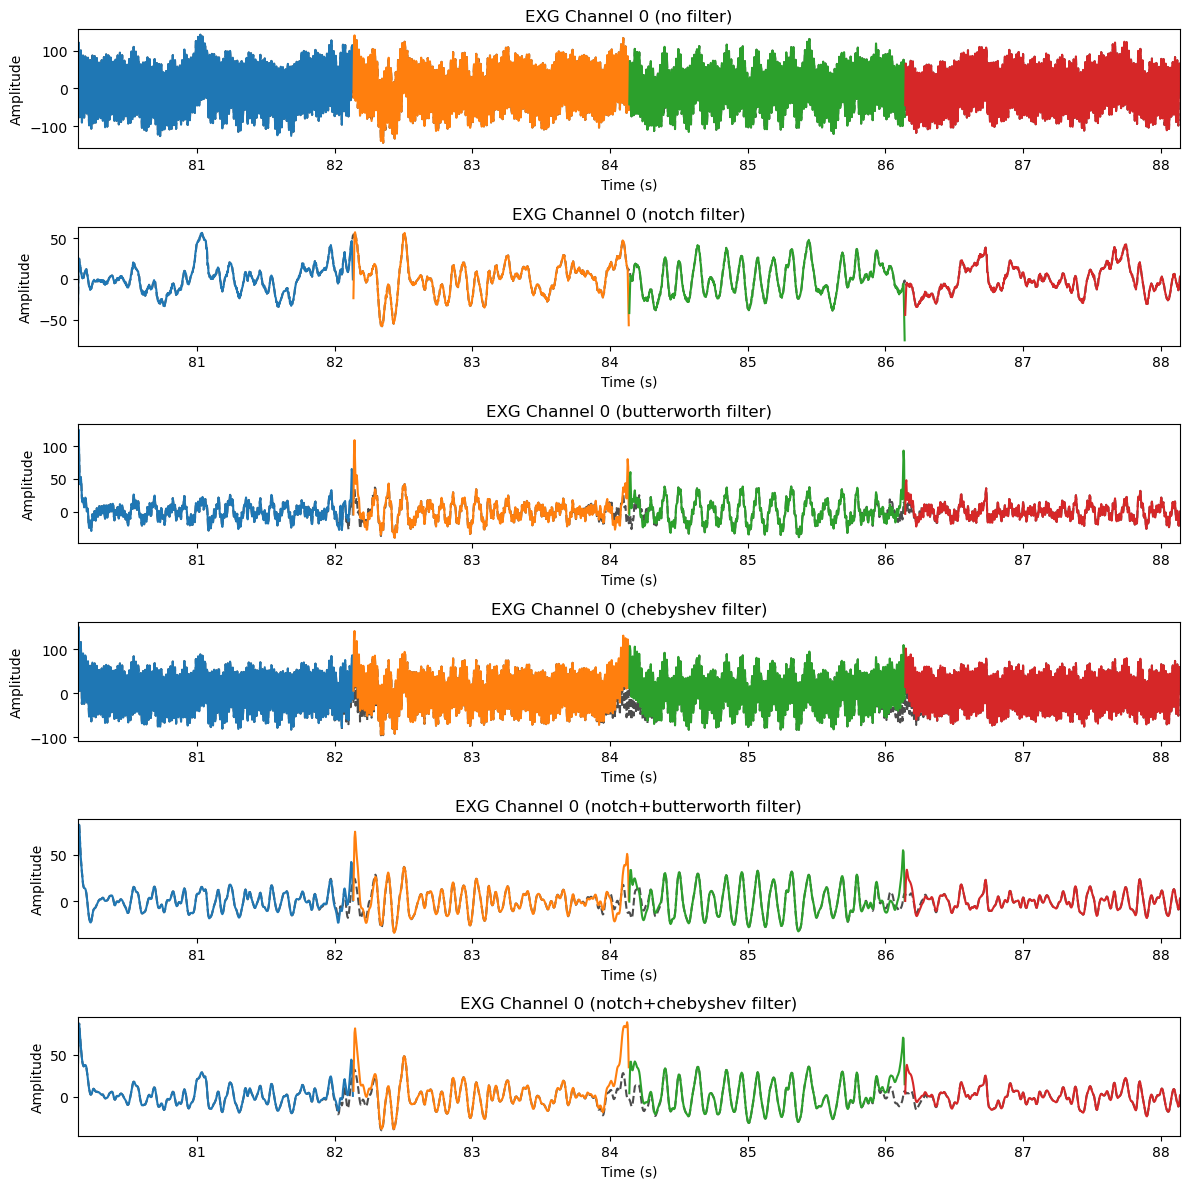

In [32]:

filter_names = ['no', 'notch', 'butterworth', 'chebyshev', 'notch+butterworth', 'notch+chebyshev']
# filter_names = ['no', 'notch', 'realtime notch', 'notch+butterworth', 'realtime notch+butterworth', 'notch+chebyshev', 'realtime notch+chebyshev']

filter_functions = {
    'no': (lambda data: filter_signal(data, notch=False, bandpass_fn=None)),
    'notch': (lambda data: filter_signal(data, notch=True, bandpass_fn=None, filter_type='offline')),
    'butterworth': (lambda data: filter_signal(data, notch=False, bandpass_fn=butter_filter, filter_type='offline')),
    'chebyshev': (lambda data: filter_signal(data, notch=False, bandpass_fn=cheby_filter, filter_type='offline')),
    'notch+butterworth': (lambda data: filter_signal(data, notch=True, bandpass_fn=butter_filter, filter_type='offline')),
    'notch+chebyshev': (lambda data: filter_signal(data, notch=True, bandpass_fn=cheby_filter, filter_type='offline')),
    'realtime notch': 
        (lambda data, notch_zi, bp_zi: filter_signal(data, notch=True, bandpass_fn=None, filter_type='realtime', notch_zi=notch_zi, bp_zi=bp_zi)),
    'realtime butterworth': 
        (lambda data, notch_zi, bp_zi: filter_signal(data, notch=False, bandpass_fn=butter_filter, filter_type='realtime', notch_zi=notch_zi, bp_zi=bp_zi)),
    'realtime chebyshev': 
        (lambda data, notch_zi, bp_zi: filter_signal(data, notch=False, bandpass_fn=cheby_filter, filter_type='realtime', notch_zi=notch_zi, bp_zi=bp_zi)),
    'realtime notch+butterworth': 
        (lambda data, notch_zi, bp_zi: filter_signal(data, notch=True, bandpass_fn=butter_filter, filter_type='realtime', notch_zi=notch_zi, bp_zi=bp_zi)),
    'realtime notch+chebyshev': 
        (lambda data, notch_zi, bp_zi: filter_signal(data, notch=True, bandpass_fn=cheby_filter, filter_type='realtime', notch_zi=notch_zi, bp_zi=bp_zi)),
}

i_channel_to_plot = 0
channel_name = channel_names[i_channel_to_plot]

remove_dc_offset = True
block_length = 0.5 # for DC offset removal, in seconds

i_trial = 10
window_length = 2 # in seconds

# time_start = 8 # in seconds
# window_length = 2 # in seconds
# n_windows = 4
# i_time_start = fs*time_start
# i_time_stop = i_time_start + (fs * window_length * n_windows)

trial_data = df_data.loc[df_data['Trial'] == i_trial, channel_name]

i_time_start = trial_data.index[0]
i_time_stop = trial_data.index[-1]
n_windows = (i_time_stop - i_time_start) / (fs * window_length)

# remove DC offset
if remove_dc_offset:
    n_blocks = math.ceil(len(trial_data)/(block_length*fs))
    for block in np.array_split(trial_data, n_blocks):
        trial_data.loc[block.index] = block - np.mean(block)

n_rows = len(filter_names)
n_cols = 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows*2))

for filter_name, ax in zip(filter_names, axes):

    notch_zi = None
    bp_zi = None

    if 'realtime' in filter_name:
        trial_data_filtered, _, _ = filter_functions[filter_name](trial_data, None, None)
    else:
        trial_data_filtered = filter_functions[filter_name](trial_data)
    ax.plot(trial_data.index / fs, trial_data_filtered, color='black', linestyle='--', alpha=0.7)

    for window in np.array_split(trial_data, n_windows):

        if 'realtime' in filter_name:
            window_filtered, notch_zi, bp_zi = filter_functions[filter_name](window, notch_zi, bp_zi)
        else:
            window_filtered = filter_functions[filter_name](window)

        ax.plot((window.index / fs), window_filtered, alpha=1)

    ax.set_xlim(i_time_start / fs, i_time_stop / fs)

    ax.set_title(f'{channel_name} ({filter_name} filter)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

fig.tight_layout()

prefix = 'filtfilt'
fig.savefig(f'{prefix}_{"without" if remove_dc_offset else "with"}_dc_offset.png', dpi=300, bbox_inches='tight')
